# Functional Connectivity Length Test

### Import modules

In [97]:
## import libraries 
import os
from pathlib import Path
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
import seaborn as sns 
from scipy.stats import ttest_ind
import networkx as nx

In [98]:
## define path variables 
DATA_PATH = "/Users/praveslamichhane/Desktop/alzheimers/data/1CLT" ## path to where the data is mounted

### Load data

In [106]:
dF_F = np.load(os.path.join(DATA_PATH, "dF_F.npy")) ## load the dF_F data

### Define Global Variables

In [107]:
## set global variables
NUM_CELLS = dF_F.shape[0]
NUM_POINTS = dF_F.shape[1]
FRAME_RATE = 15.49 ## this should not be hard coded 

print(NUM_CELLS, NUM_POINTS)

72 41823


### Define plotting functions

In [108]:
## plot the spiking of subset of cells
## define function to plot spikes
def plot_spikes_subset(spks_cell, time_points=50, cell_indices=None):
    # np.random.seed(100)
    # someCells = np.random.choice(NUM_CELLS, 10) ## select 10 random cells
    if cell_indices is not None:
        cell_indices = np.array(list(cell_indices))
        for i in cell_indices:
            if i >= spks_cell.shape[0]:
                raise ValueError("Cell index out of range")
        someCells = np.array(cell_indices)
    else:
        someCells = np.array(list(np.arange(10)))
    
    num_rows = int(len(someCells) // np.sqrt(len(someCells)))
    num_cols = int(np.ceil(len(someCells) / num_rows))
    # print(num_rows, num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))  
    axes = axes.flatten()

    for i, cell_idx in enumerate(someCells):
        axes[i].plot(spks_cell[int(cell_idx), :time_points])
        axes[i].set_title("Cell: " + str(someCells[i] + 1))
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("dF/F")
        axes[i].set_ylim(-10, 50)

    plt.tight_layout()
    plt.show()

### Introduce artefactual data for validation 

In [102]:
## add some new cells with correlated activity 
arte_cell_0 = np.array(dF_F[0, :] + 10) ## perfect positive correlation
arte_cell_1 = np.array(dF_F[0, :] + np.random.normal(0, 1)) ## add noise here but still correlated
arte_cell_2 = np.array(-dF_F[0, :]) ## perfect negative correlation
arte_cell_3 = np.array(np.random.normal(0, 1, NUM_POINTS)) ## random noise so no correlation

In [103]:
# dF_F = np.vstack((dF_F, arte_cell_0, arte_cell_1, arte_cell_2, arte_cell_3))

In [109]:
print(dF_F.shape)

(72, 41823)


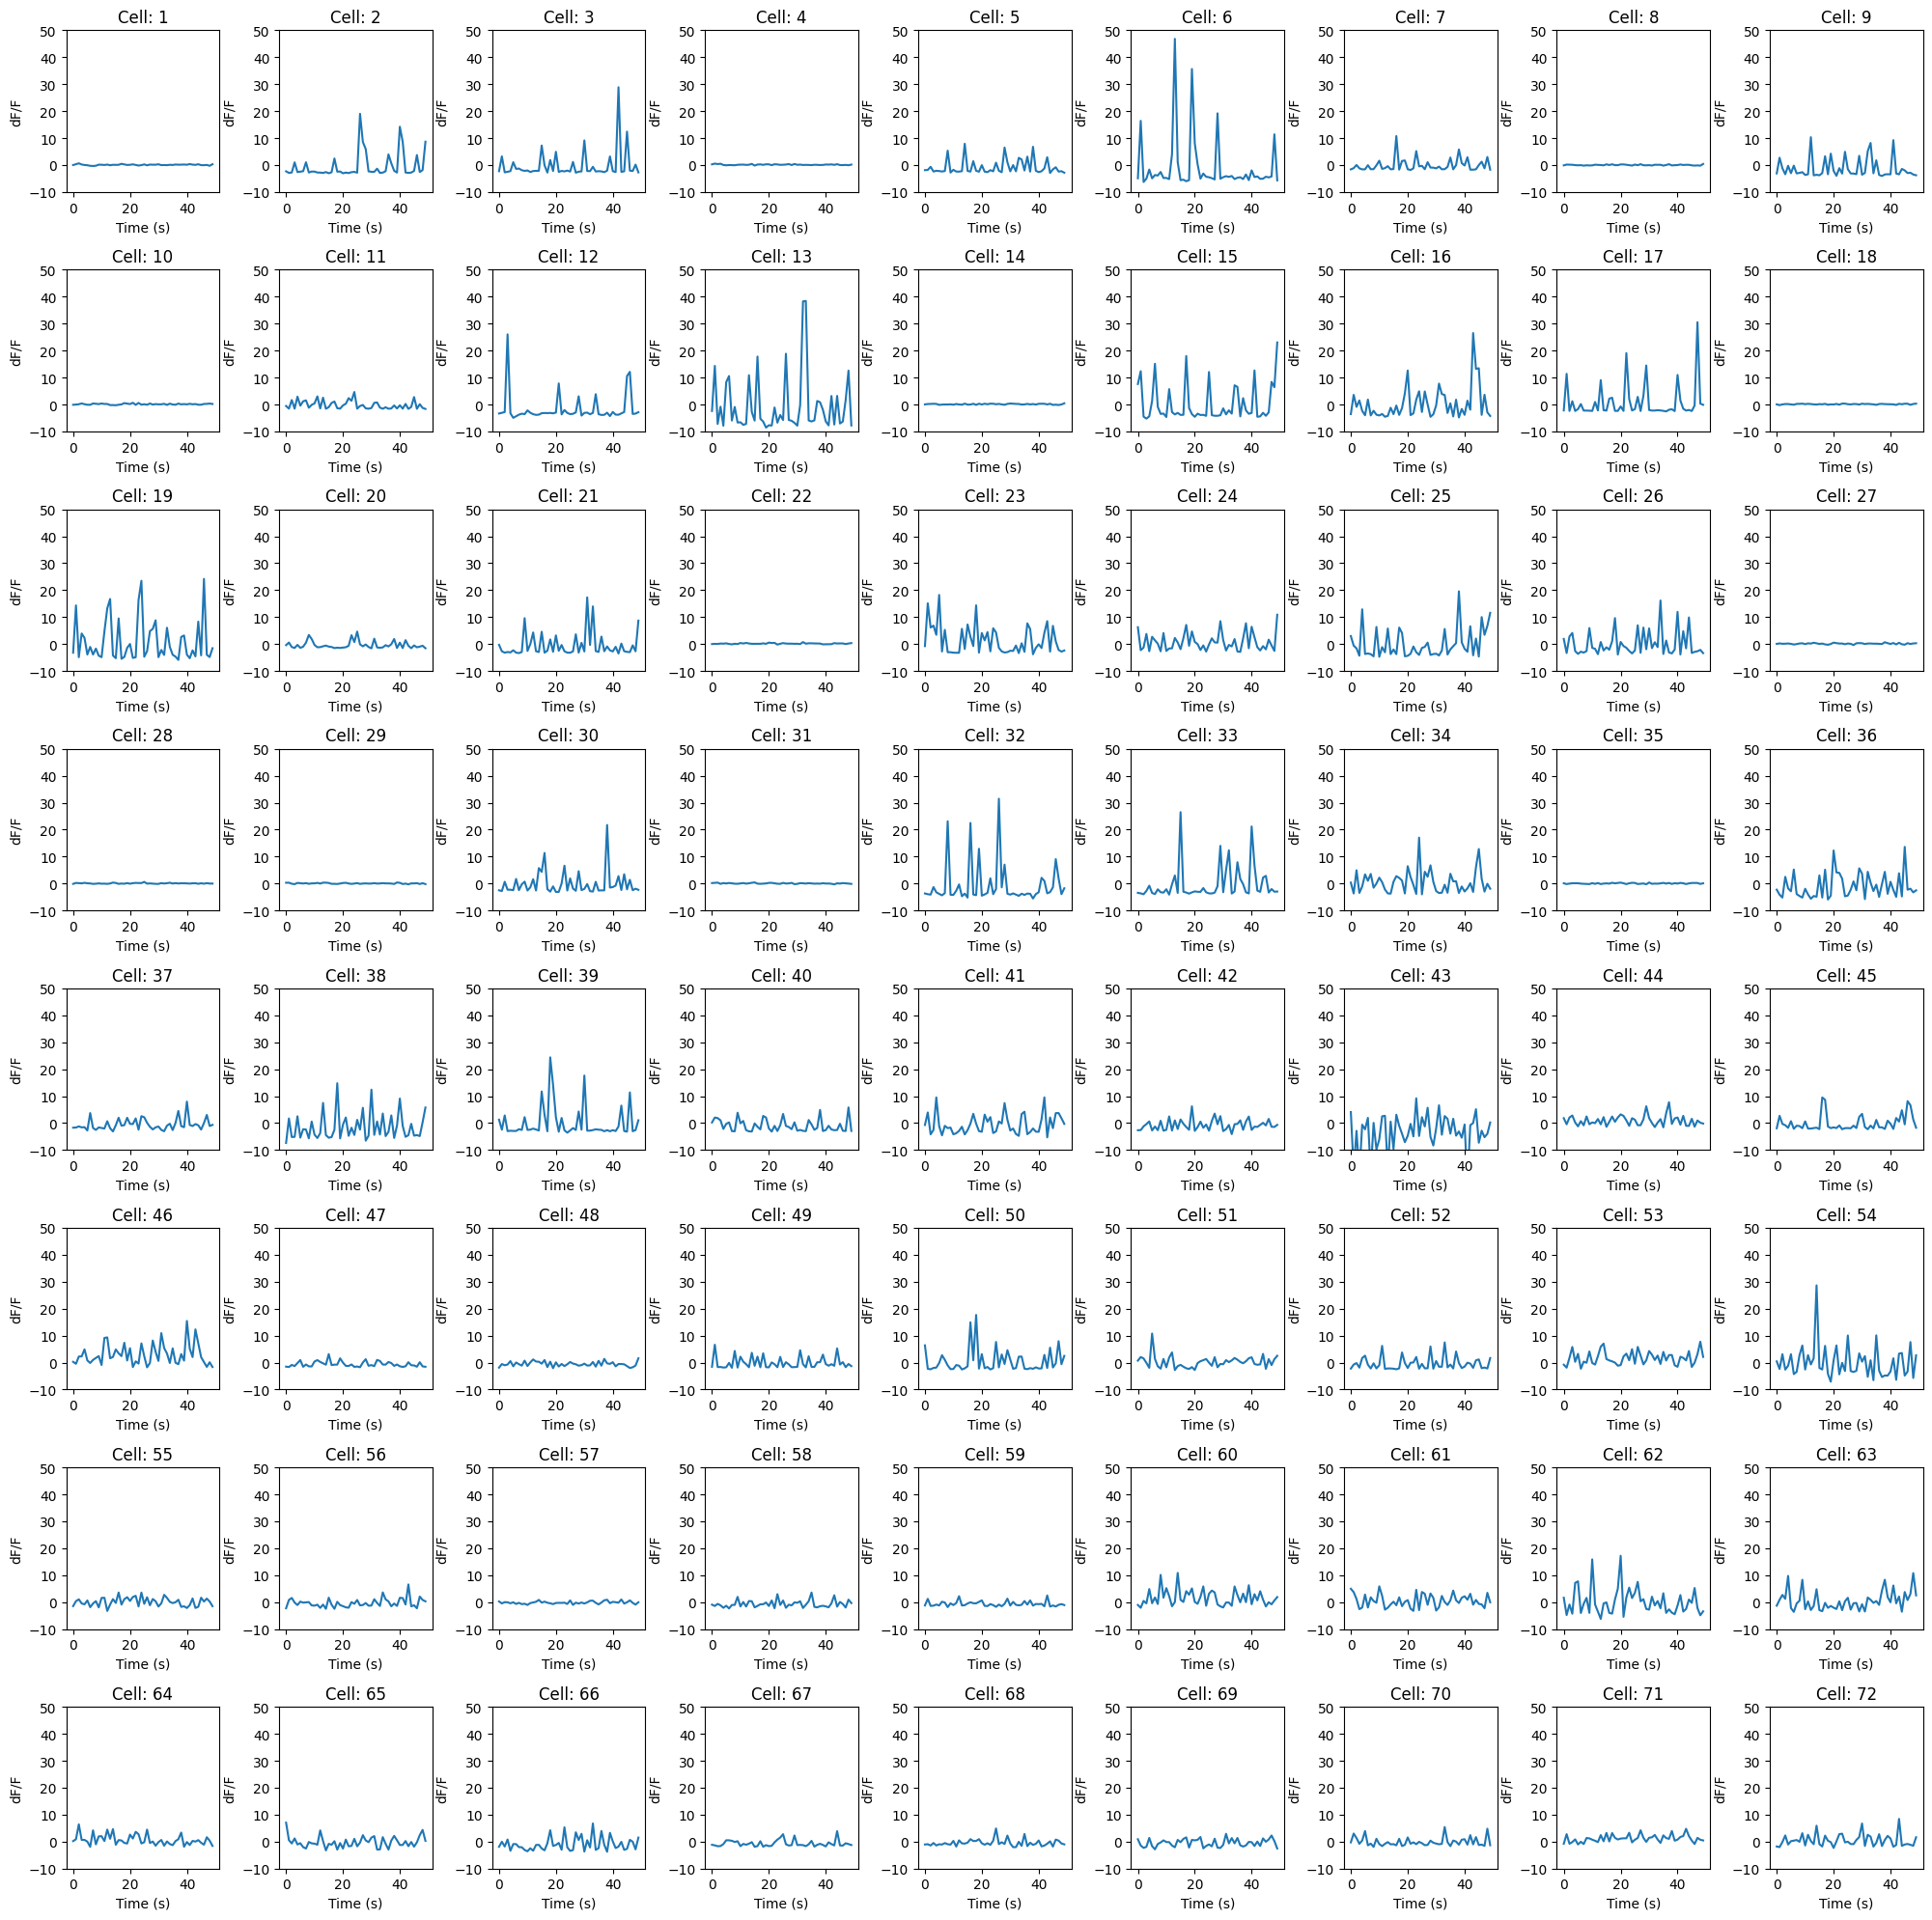

In [110]:
plot_spikes_subset(dF_F, cell_indices=np.arange(dF_F.shape[0]))

### Convolve with a Gaussian filter to obtain FC network.

In [115]:
## convolve the spikes with a gaussian filter
def convolve_spikes(spks, sigma=1):
    convolved_spks = np.zeros(spks.shape)
    for i in range(spks.shape[0]):
        convolved_spks[i, :] = gaussian_filter1d(spks[i, :], sigma)
    return convolved_spks

In [129]:
convolved_dF_F = convolve_spikes(dF_F, sigma=10)

### Subset data according to the length of recording 

In [130]:
## define a function to subset the data 
def subset_data(data, num_points):
    num_cells = data.shape[0]
    data_subset = np.zeros((num_cells, num_points))

    for i in range(num_cells):
        data_subset[i] = data[i][:num_points]

    return data_subset

In [131]:
data_subset = {}

time_keys = [10, 15, 20, 30, 40, 45] ## this is in minutes 
print(type(time_keys[0]))
for time in time_keys:
    if time != 45:
        data_subset[time] = subset_data(convolved_dF_F, int(time*FRAME_RATE*60))
    else:
        data_subset[time] = convolved_dF_F 

## check the shape of the data
for time in data_subset.keys():
    print(f"The shape of the data for time {time} is {data_subset[time].shape}")

<class 'int'>
The shape of the data for time 10 is (72, 9294)
The shape of the data for time 15 is (72, 13941)
The shape of the data for time 20 is (72, 18588)
The shape of the data for time 30 is (72, 27882)
The shape of the data for time 40 is (72, 37176)
The shape of the data for time 45 is (72, 41823)


### Functional Connectivity using Pearson's correlation for all lengths

### Calculate correlation matrices

In [146]:
## calculate the correlation matrix for each time point
correlation_matrices = {}

for time in data_subset.keys():
    correlation_matrices[time] = np.corrcoef(data_subset[time])

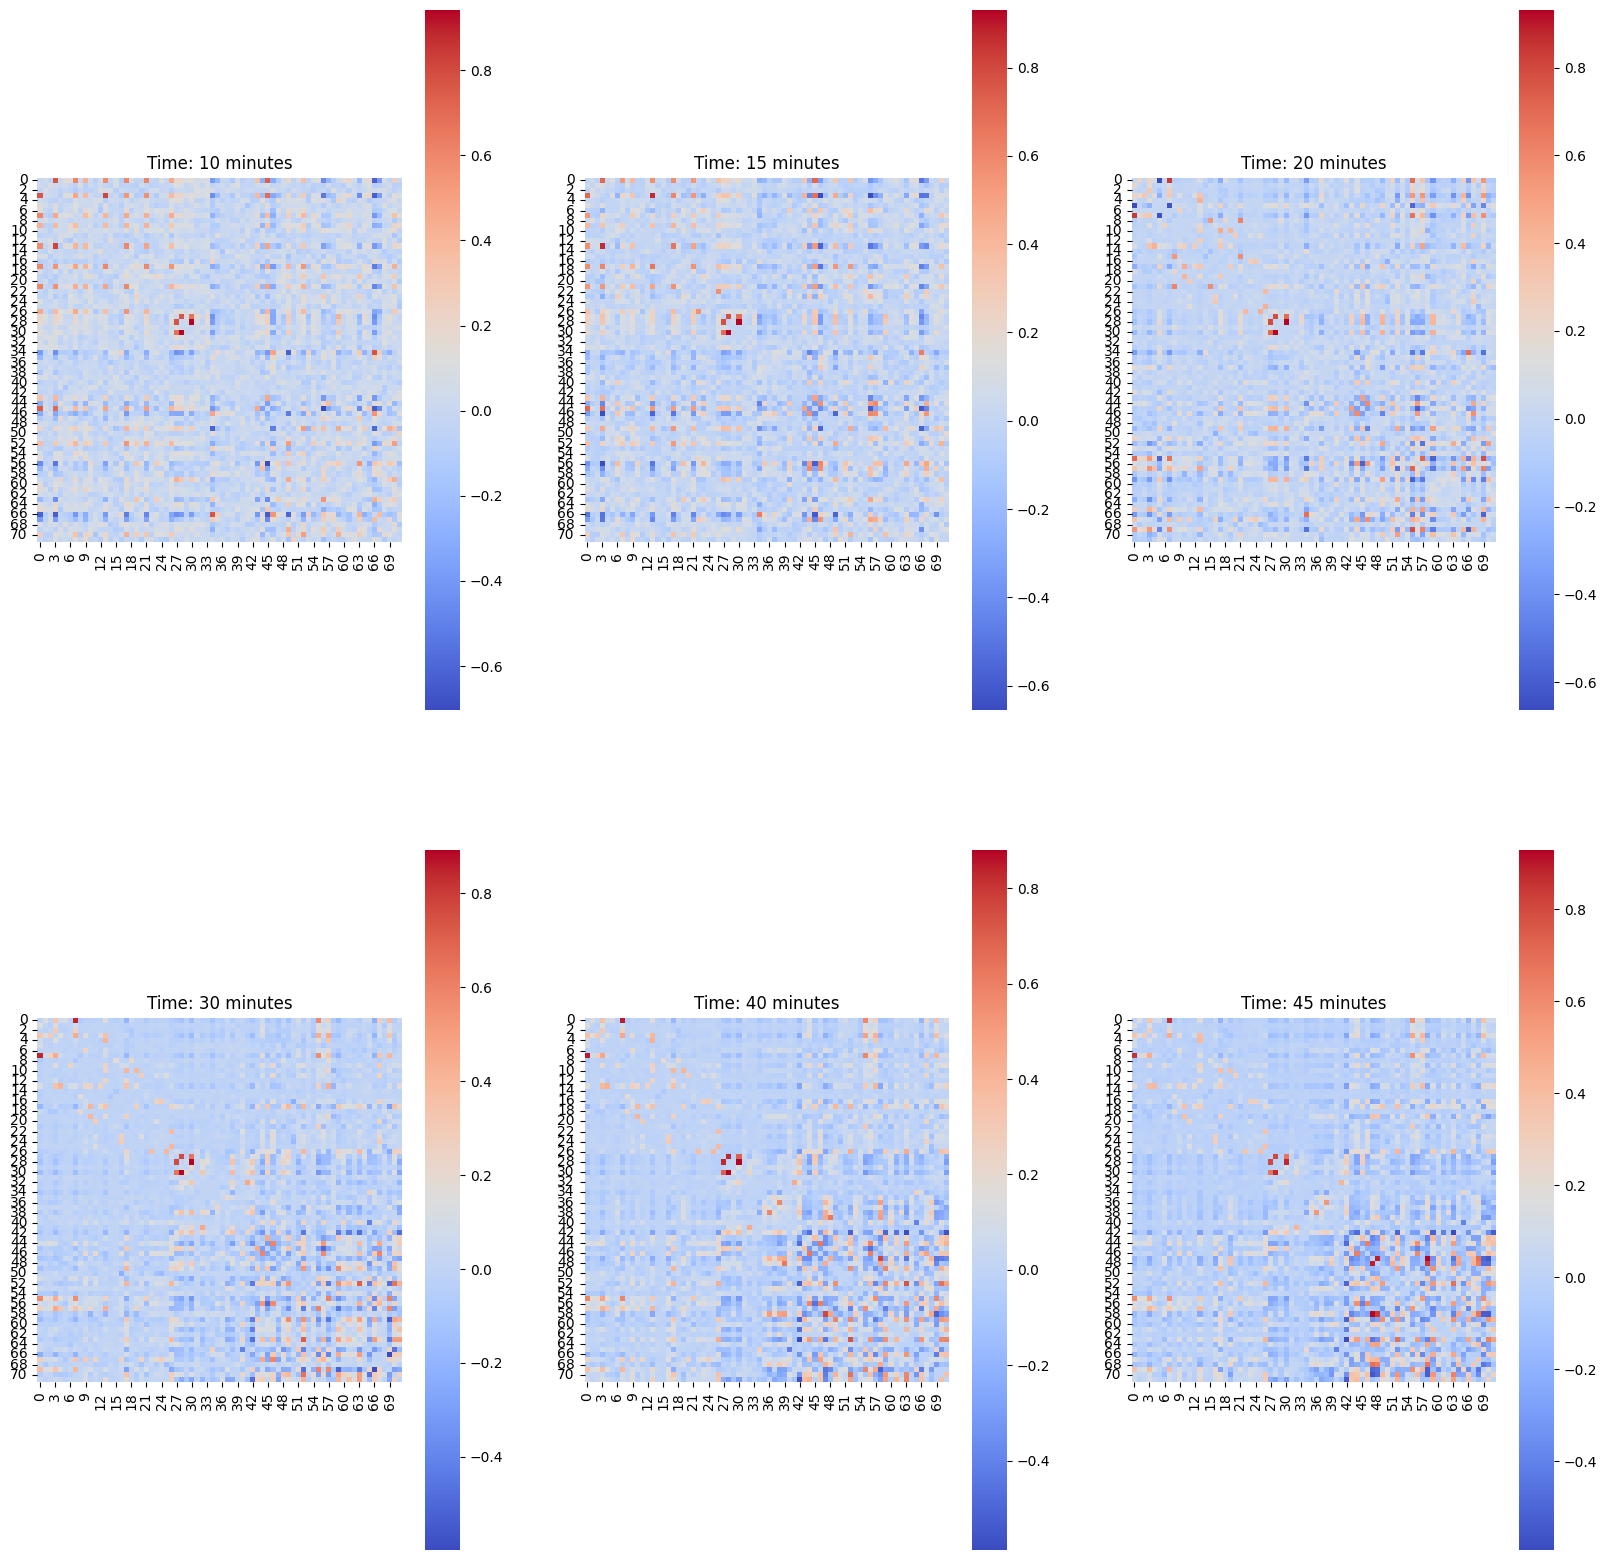

In [147]:
## plot the correlation matrix for each time point
## make the plot square 
num_rows = int(len(time_keys) // np.sqrt(len(time_keys)))
num_cols = int(len(time_keys) // num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

## create clustered heatmap for each time point
for time in time_keys:
    mat = correlation_matrices[time].copy()
    np.fill_diagonal(mat, 0) ## fill diagonal with 0s
    sns.heatmap(mat, ax=axes[time_keys.index(time)], cmap="coolwarm", square=True)
    axes[time_keys.index(time)].set_title(f"Time: {time} minutes")

plt.show()

### Binarize both the correlation and partial correlation matrices for clustering. -> did not implement this as we lose the actual correlation and replace it with 1. 

In [148]:
def binarize_matrix_absolute(matrix, threshold):
    binary_matrix = np.zeros(matrix.shape)
    binary_matrix[matrix >= threshold] = 1

    return binary_matrix 

def binarize_matrix_proportional(matrix, proportion):
    ## needs numpy to be imported as np
    # Step 1: Get the upper triangle indices (ignoring the diagonal)
    triu_indices = np.triu_indices_from(matrix, k=1)

    # Step 2: Extract the upper triangle values of the correlation matrix (ignoring the diagonal)
    upper_triangle_values = matrix[triu_indices]

    # Step 3: Sort the values and determine the 50% threshold
    threshold_value = np.percentile(upper_triangle_values, proportion)

    # Step 4: Binarize the matrix - keep top 50% of connections
    binarized_matrix = np.zeros_like(matrix)
    binarized_matrix[np.abs(matrix) >= threshold_value] = 1
    return binarized_matrix

### Generate clustered heatmap of the correlation matrices 

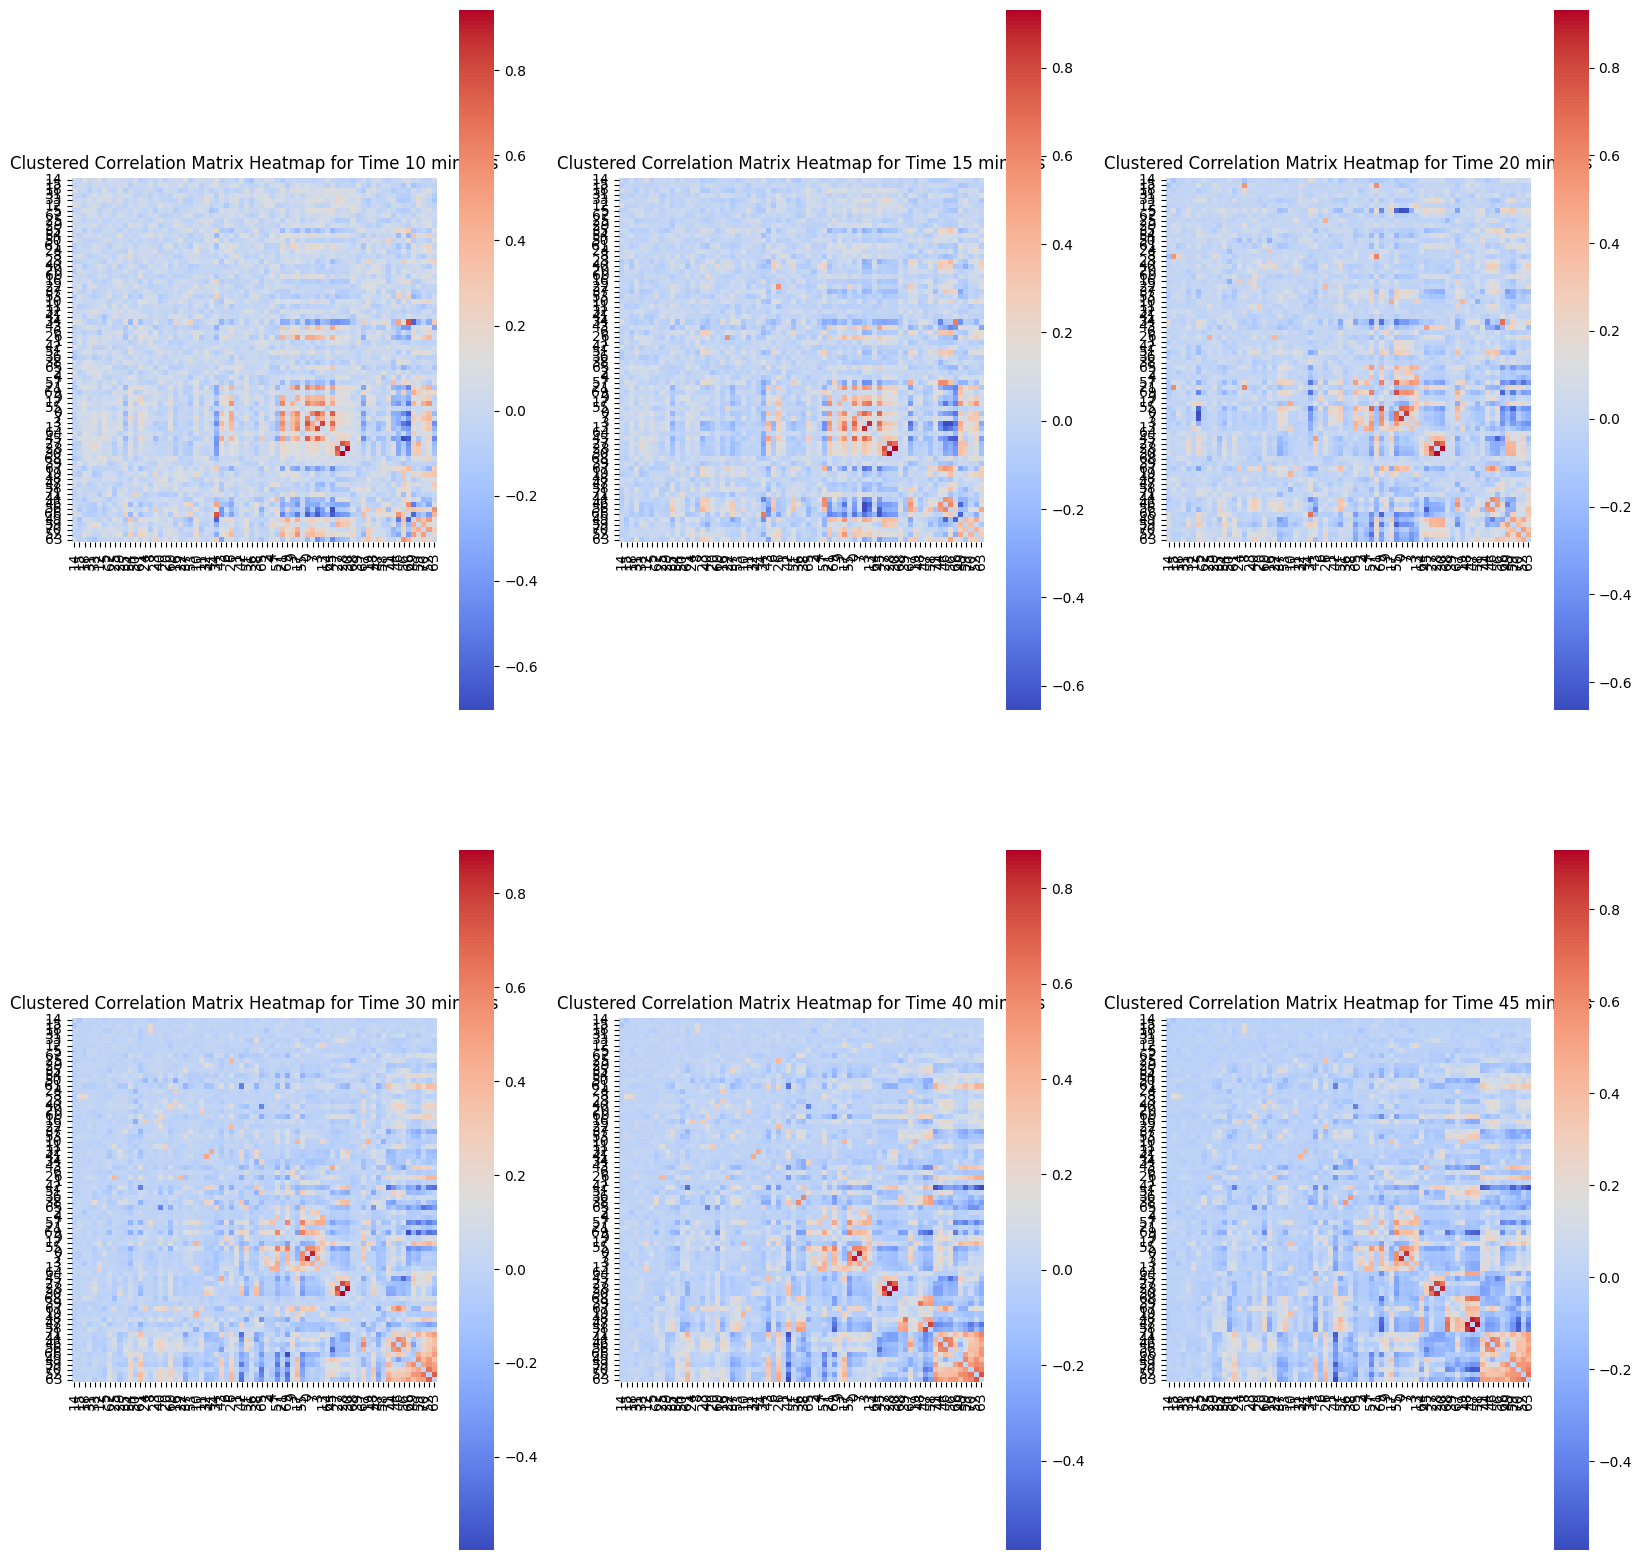

In [150]:
## make the plot square 
num_rows = int(len(time_keys) // np.sqrt(len(time_keys)))
num_cols = int(len(time_keys) // num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

## create clustered heatmap for each time point
for time in time_keys:
    
    # Calculate the correlation matrix
    correlation_matrix = correlation_matrices[time]
    np.fill_diagonal(correlation_matrix, 0)
    
    # ## binarize the correlation matrix
    # binarized_corr_matrix = binarize_matrix_proportional(correlation_matrix, 80)

    # Perform hierarchical clustering
    Z = linkage(dF_F, metric='correlation')

    ## Get the order of rows/columns after clustering
    ordered_indices = leaves_list(Z)

    # Reorder the correlation matrix according to the clustering
    clustered_corr_matrix = correlation_matrix[ordered_indices, :][:, ordered_indices]
    # np.fill_diagonal(clustered_corr_matrix, 0)

    ax = axes[time_keys.index(time)]

    sns.heatmap(clustered_corr_matrix, annot=False, cmap='coolwarm', square=True,
                xticklabels=ordered_indices, yticklabels=ordered_indices, ax=ax)
    ax.set_title(f'Clustered Correlation Matrix Heatmap for Time {time} minutes')   

plt.show()

#### Invert the correlation matrix to calulate the partial correlation as suggested in Salvador et al. (2005)

In [145]:
## computing partial correlation by inverting the correlation matrix
partial_corr = {}
for time in correlation_matrices.keys():
    try:
        precision_matrix = np.linalg.inv(correlation_matrices[time])
        # print("Matrix is invertible")
        # print(np.less(np.diag(precision_matrix), 0))
    except:
        precision_matrix = np.linalg.pinv(correlation_matrices[time]) ## psuedo inverse if the matrix is singular
        # print("Matrix is not invertible. Using pseudo inverse.")
        # print(np.less(np.diag(precision_matrix), 0))

    print(True in np.less(np.diag(precision_matrix), 0)) ## negative values in the diagonal
    # print(True in np.less(np.outer(np.diag(precision_matrix), np.diag(precision_matrix)), 0)) ## negative values in the diagonal
    partial_corr[time] = -precision_matrix / np.sqrt(np.outer(np.diag(precision_matrix), np.diag(precision_matrix))) ## does element wise division

    np.fill_diagonal(partial_corr[time], 1)
# print(np.diag(partial_corr[10]))
# print(np.diag(partial_corr[30]))

True
True
True
True
True
True


/var/folders/y1/qf1h159d6yl_snvyz1tt9cm00000gn/T/ipykernel_17730/3614385642.py:15: RuntimeWarning: invalid value encountered in sqrt
  partial_corr[time] = -precision_matrix / np.sqrt(np.outer(np.diag(precision_matrix), np.diag(precision_matrix))) ## does element wise division


In [142]:
## check the max and min values of the partial correlation matrix
for time in partial_corr.keys():
    print(f"Time: {time} minutes")
    condition_number = np.linalg.cond(partial_corr[time])
    print(f"Condition number: {condition_number}") ## what does this actually mean?
    print(f"Max value: {np.max(partial_corr[time])}")
    print(f"Min value: {np.min(partial_corr[time])}")

Time: 10 minutes


LinAlgError: SVD did not converge

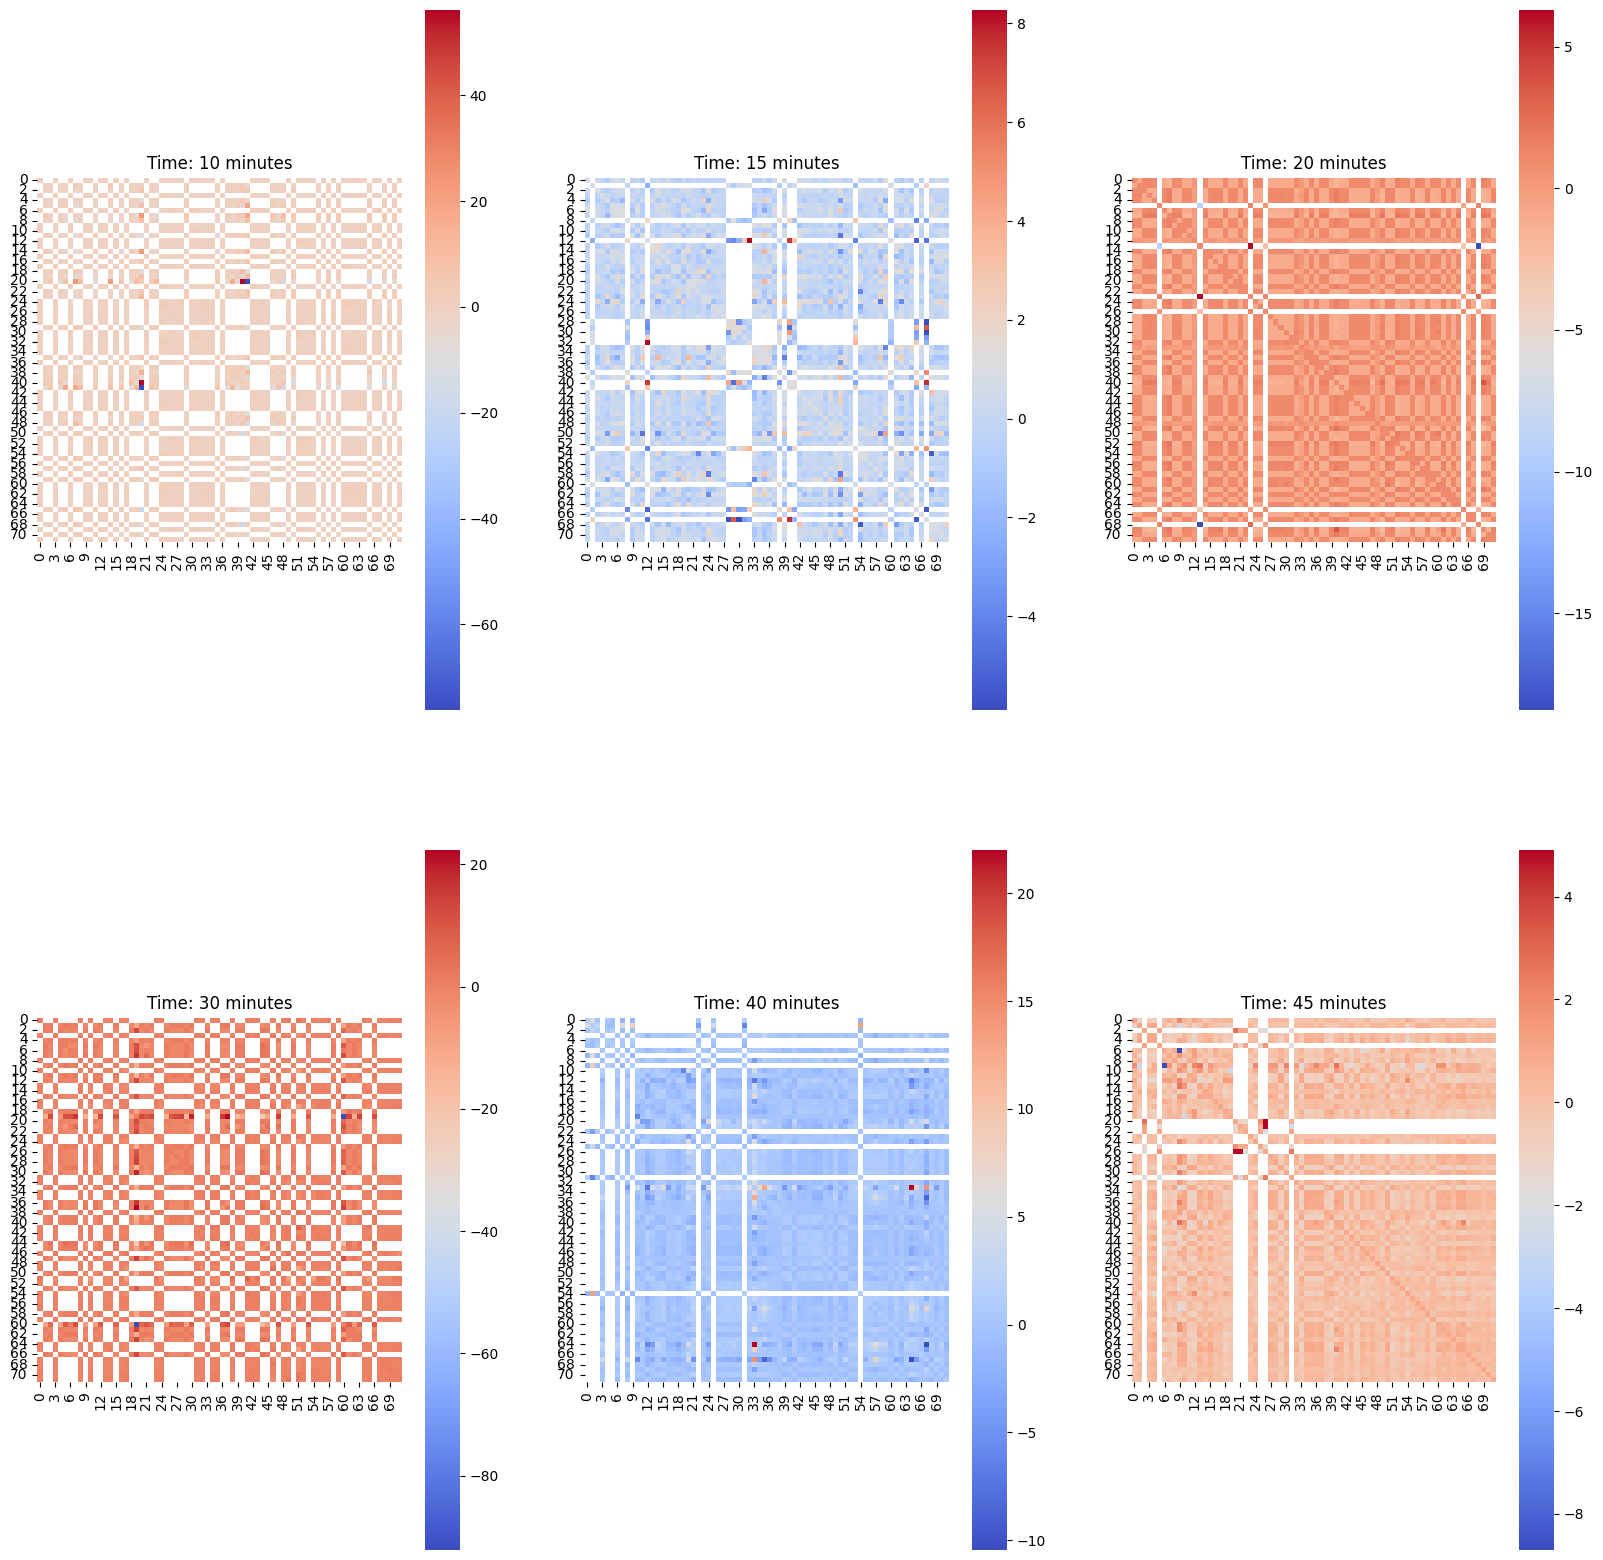

In [143]:
## plot the partial correlation matrix for each time point
## make the plot square 
num_rows = int(len(time_keys) // np.sqrt(len(time_keys)))
num_cols = int(len(time_keys) // num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

## create clustered heatmap for each time point
for time in time_keys:
    sns.heatmap(partial_corr[time], ax=axes[time_keys.index(time)], cmap="coolwarm", square=True)
    axes[time_keys.index(time)].set_title(f"Time: {time} minutes")

plt.show()

In [51]:
a = np.array([[0, 0.5, 0.6], [0.5, 0, 0.7], [0.6, 0.7, 0], [0.8, 0.9, 0.1]])
print(a)
print(binarize_matrix_proportional(a, 50))
print(binarize_matrix_absolute(a, 0.6))

[[0.  0.5 0.6]
 [0.5 0.  0.7]
 [0.6 0.7 0. ]
 [0.8 0.9 0.1]]
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 0.]
 [1. 1. 0.]]
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 0.]
 [1. 1. 0.]]


### Clustered heatmap of partial matrices

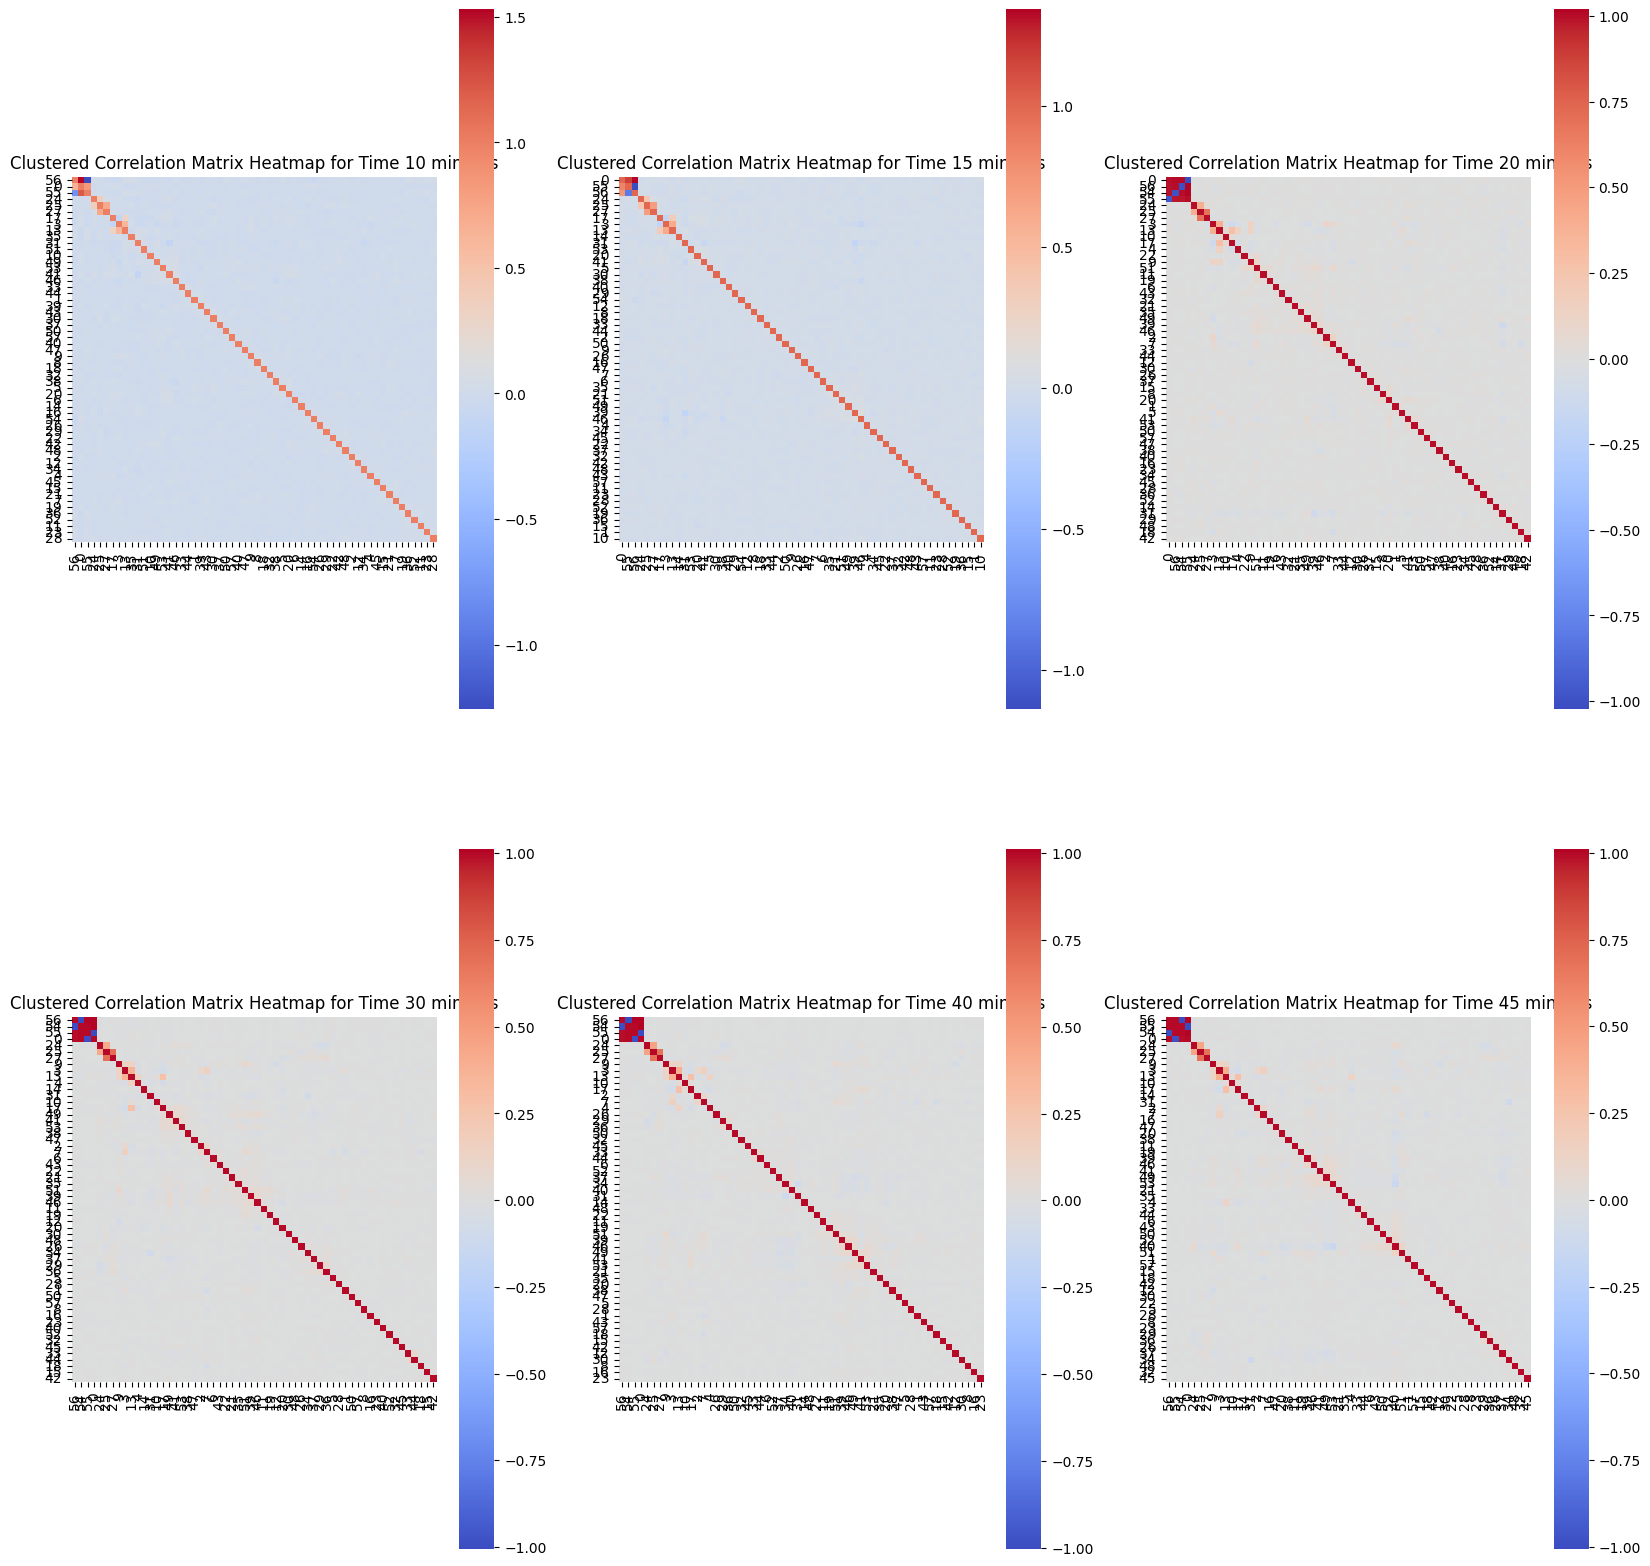

In [53]:
## make the plot square 
num_rows = int(len(time_keys) // np.sqrt(len(time_keys)))
num_cols = int(len(time_keys) // num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

## create clustered heatmap for each time point
for time in time_keys:
    
    # Calculate the correlation matrix
    correlation_matrix = partial_corr[time]

    # Perform hierarchical clustering
    Z = linkage(correlation_matrix, method='average')

    # Get the order of rows/columns after clustering
    ordered_indices = leaves_list(Z)

    # Reorder the correlation matrix according to the clustering
    clustered_corr = correlation_matrix[ordered_indices, :][:, ordered_indices]
    # np.fill_diagonal(clustered_corr, 0)

    ax = axes[time_keys.index(time)]

    sns.heatmap(clustered_corr, annot=False, cmap='coolwarm', square=True,
                xticklabels=ordered_indices, yticklabels=ordered_indices, ax=ax)
    ax.set_title(f'Clustered Correlation Matrix Heatmap for Time {time} minutes')   

plt.show()

### The networks we have constructed are weighted undirected networks because it is just a correlation matrix.
The analyses from this point is going to use the networkx library from here on. 

#### Degree distribution and assortativity 
The degree distribution of a complex network is generally non-gaussian. Scale-free networks follow a power law degree distribution. 

NameError: name 'eng' is not defined

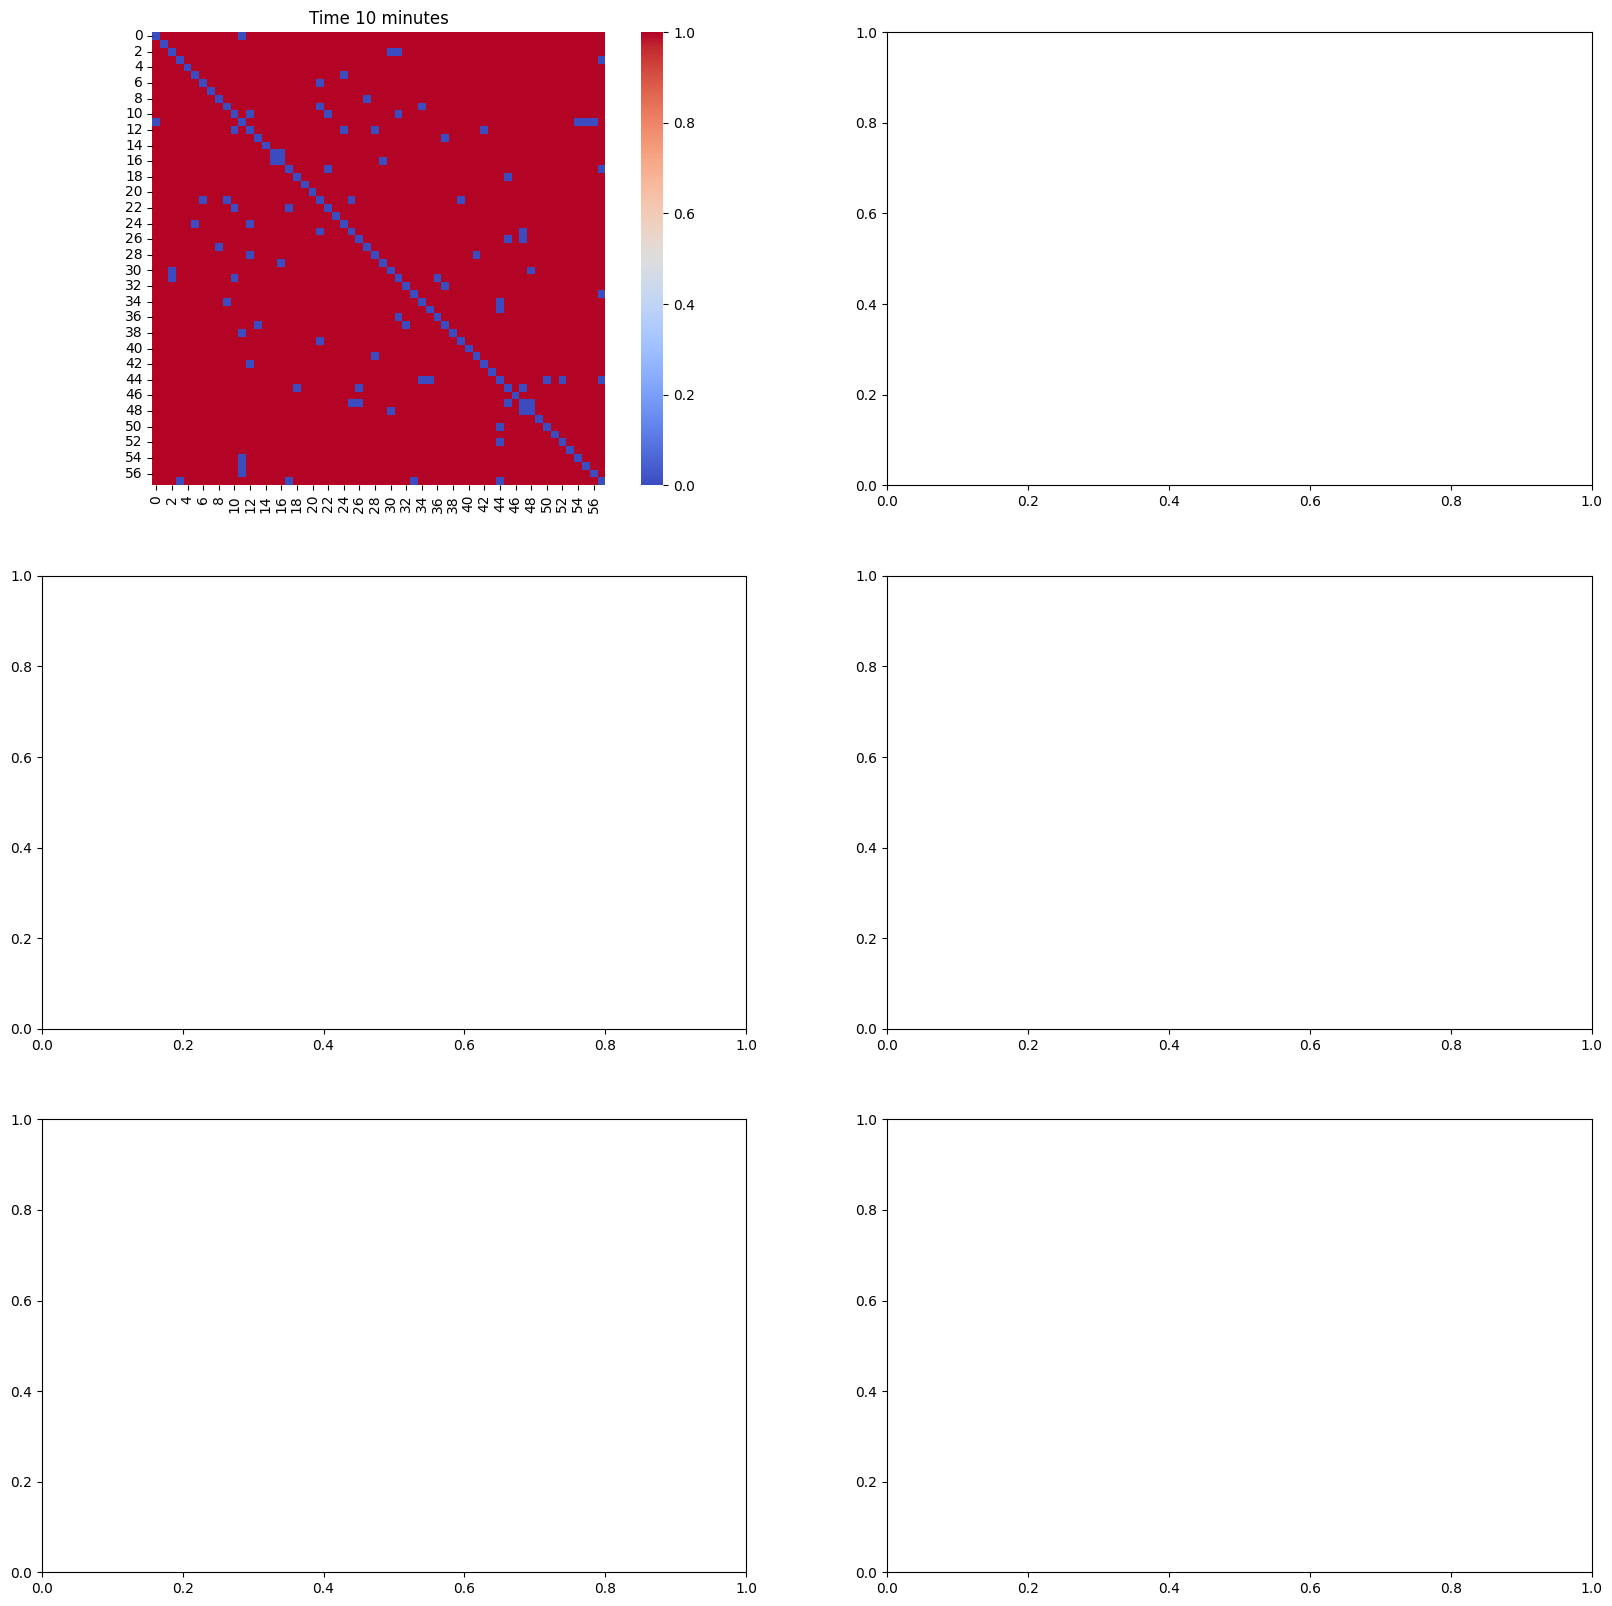

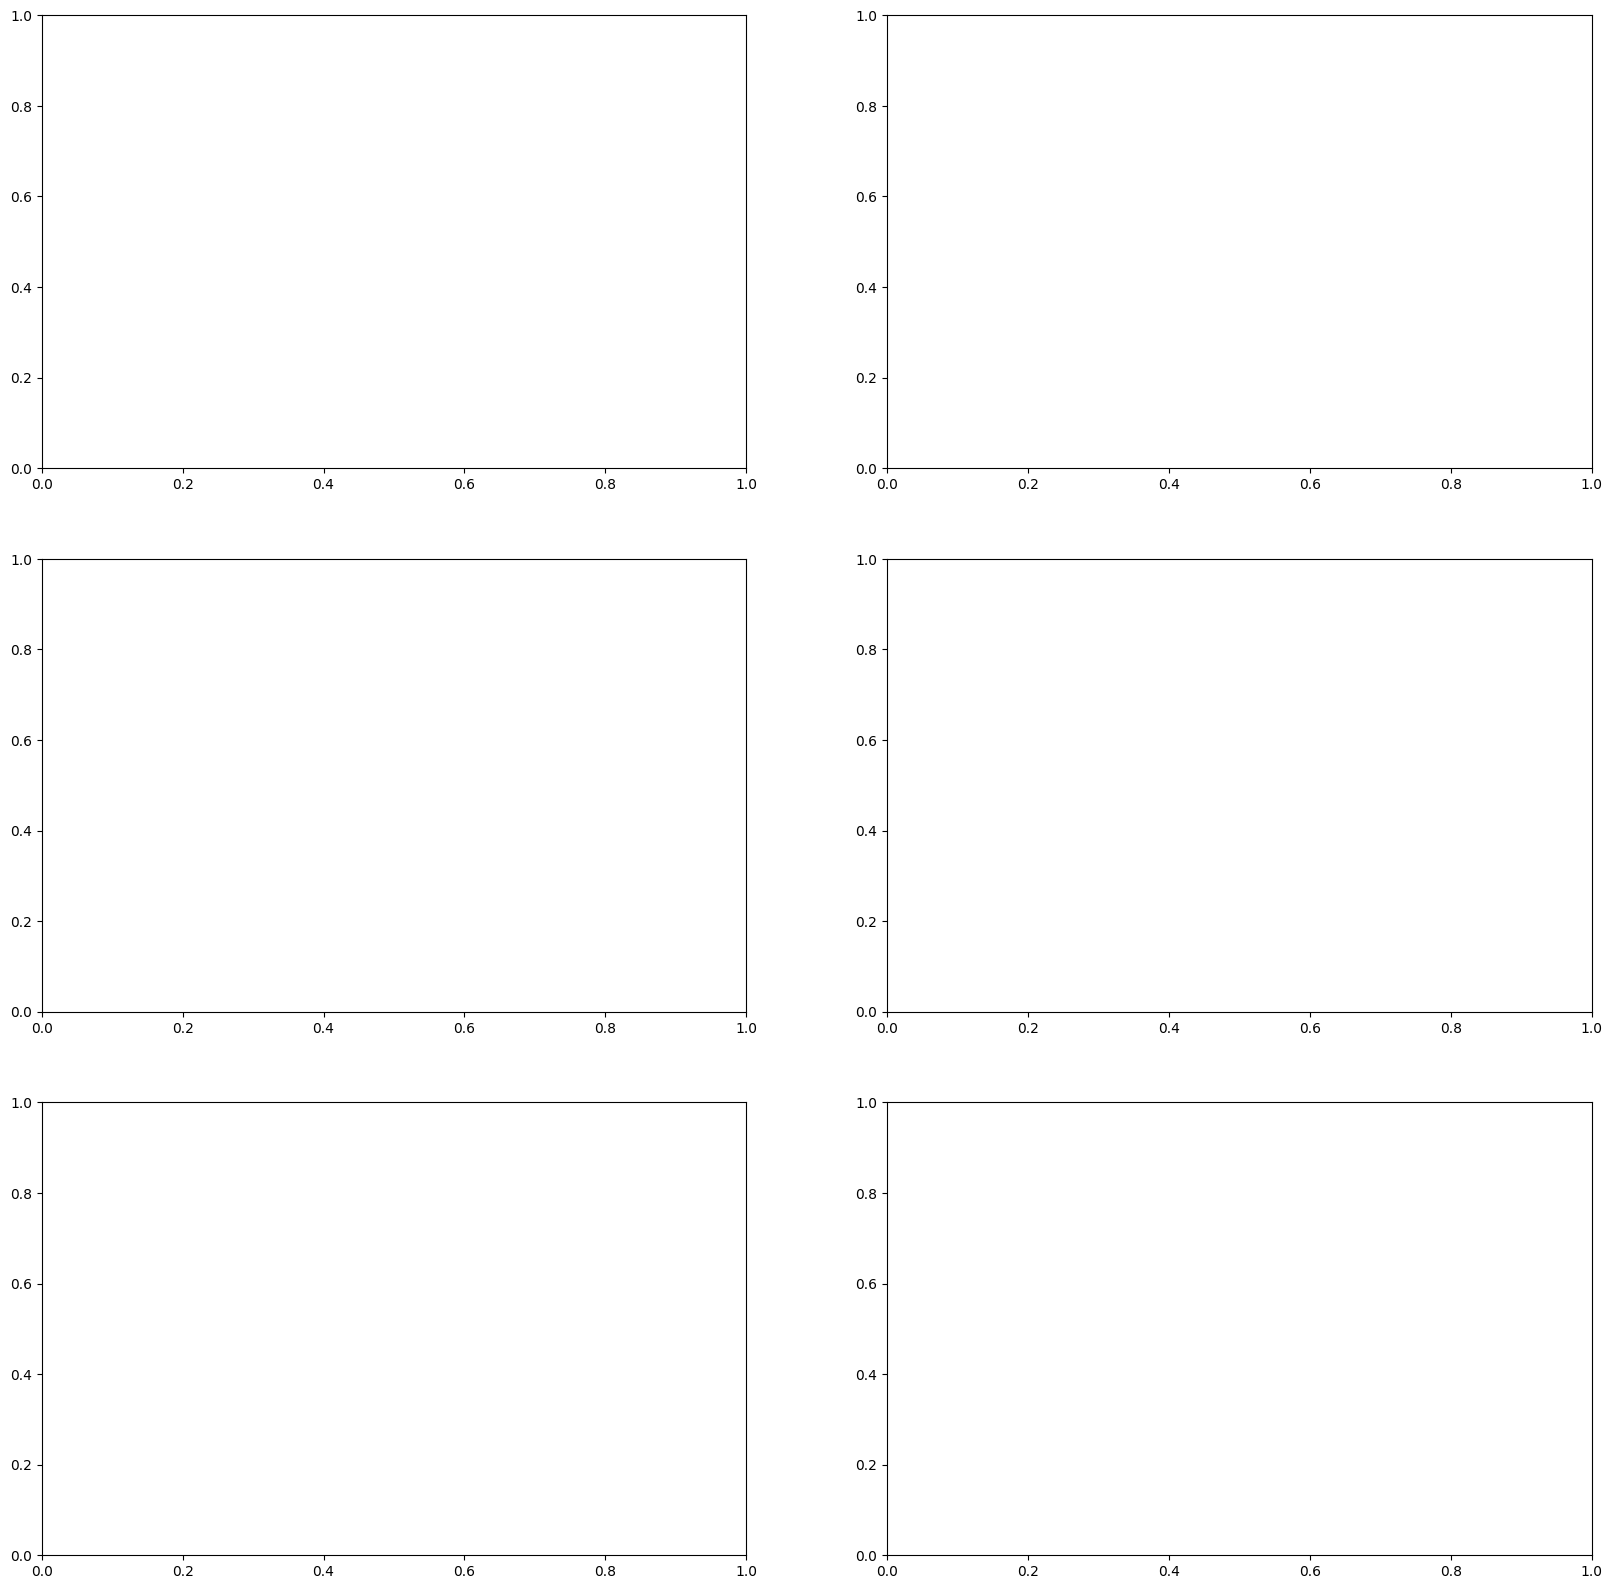

In [54]:
# Calculate the number of rows and columns to make the plot layout square
num_rows = int(np.ceil(np.sqrt(len(time_keys))))
num_cols = int(np.ceil(len(time_keys) / num_rows))

# Create subplots for correlation matrices and degree distributions
fig_corr, axes_corr = plt.subplots(num_rows, num_cols, figsize=(20, 20))
fig_deg, axes_deg = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Flatten the axes array to simplify indexing
axes_corr = axes_corr.flatten()
axes_deg = axes_deg.flatten()

for i, time in enumerate(time_keys):
    ## Create a threshold matrix 
    # mat = np.array(eng.threshold_proportional(correlation_matrices[time], 0.8))
    mat = binarize_matrix_proportional(correlation_matrices[time], 50)    

    # Plot the heatmap of the thresholded correlation matrix
    ax_corr = axes_corr[i]
    sns.heatmap(mat, annot=False, cmap='coolwarm', square=True, ax=ax_corr)
    ax_corr.set_title(f'Time {time} minutes')

    # Calculate and plot the degree distribution
    d = np.array(eng.degrees_und(mat))
    d = np.reshape(d, (d.shape[1],))  # Reshape the degrees array

    ax_deg = axes_deg[i]
    ax_deg.hist(d, bins=10)
    ax_deg.set_title(f'Degree Distribution for Time {time} minutes')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the correlation matrix figure
plt.show(fig_corr)

# Show the degree distribution figure
plt.show(fig_deg)


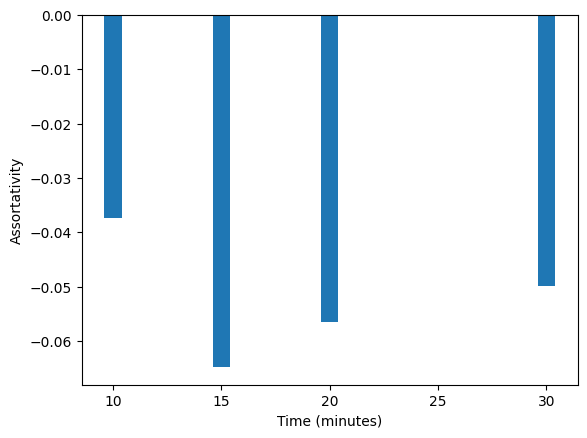

In [ ]:
## looking at the correlation of the degree distribution -> assortativity
assort = np.zeros(len(time_keys))

for i, time in enumerate(time_keys):
    mat = np.array(eng.threshold_proportional(correlation_matrices[time], 0.8))
    assort[i] = eng.assortativity_wei(mat, 0)

plt.bar(time_keys, assort)
plt.xlabel('Time (minutes)')
plt.ylabel('Assortativity')
plt.show()

#### Clustering coefficient 

0.0 1.0
(43, 1)
(43,)


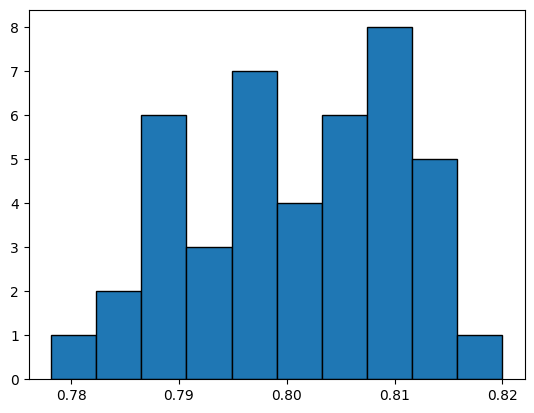

In [ ]:
## normalize weights
mat_normalized = np.array(eng.weight_conversion(mat, 'binarize'))

print(np.min(mat_normalized), np.max(mat_normalized))


cc = np.array(eng.clustering_coef_wu(mat_normalized))
print(cc.shape); cc = np.reshape(cc, (cc.shape[0],)); print(cc.shape)
plt.hist(cc, bins=10, edgecolor='black')
plt.show()

#### Path lengths and efficiency 

#### Centrality 

(43, 1)
(43,)


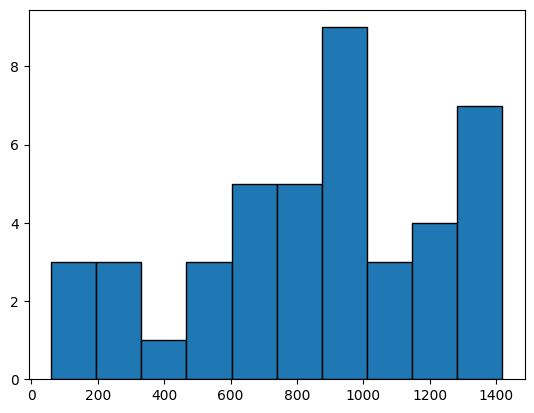

In [ ]:
bc = np.array(eng.betweenness_wei(correlation_matrices[10]))
print(bc.shape); bc = np.reshape(bc, (bc.shape[0],)); print(bc.shape)

plt.hist(bc, bins=10, edgecolor='black')
plt.show()


#### Modularity 

(43, 1)
(43,)


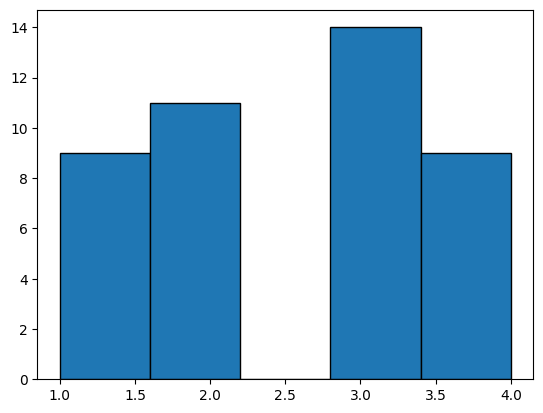

In [ ]:
modularity = np.array(eng.modularity_und(mat, 1.0))
print(modularity.shape); modularity = np.reshape(modularity, (modularity.shape[0],)); print(modularity.shape)

plt.hist(modularity, bins=5, edgecolor='black')
plt.show()